
# OpenStreetMap with OSMnx

This example shows how to use OSMnx to download and model a street network
from OpenStreetMap, visualize centrality, and save the graph as a shapefile,
a GeoPackage, or GraphML.

OSMnx is a Python package to retrieve, model, analyze, and visualize
OpenStreetMap street networks as NetworkX MultiDiGraph objects. It can also
retrieve any other spatial data from OSM as geopandas GeoDataFrames. See
https://osmnx.readthedocs.io/ for OSMnx documentation and usage.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os
import os.path
import multiprocessing as mp
import warnings
from functools import partial

import numpy as np
import networkx as nx
import osmnx as ox
import polars as pl
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from taxifare import data, boroughs

ox.settings.log_console=True
ox.settings.use_cache=True

/home/ballman/code/py/taxi/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ~ 6m 26s
# download street network data from OSM and construct a MultiDiGraph model

def load_map(base_map: str, simplified_map: str, tolerance: float) -> nx.MultiDiGraph:
    if os.path.exists(simplified_map):
        print(f"loading saved map {simplified_map}")
        H = ox.load_graphml(simplified_map)
        print(f"loaded saved map {simplified_map}")
        return H
    elif os.path.exists(base_map):
        print("Starting to simplify map. May require some time")
        H = ox.simplification._consolidate_intersections_rebuild_graph(
            ox.load_graphml(base_map), tolerance=tolerance, reconnect_edges=True)
        print(f"simplified base_map({base_map}) with tollerance = {tolerance}")
        ox.save_graphml(H, filepath=simplified_map)
        print(f"saved simplified graph: {simplified_map}")
        return H
    else:
        print("downloading graph. May require some time")
        G = ox.graph.graph_from_place("New York City, New York, USA")
        print("downloaded graph")
        G = ox.utils_graph.get_largest_component(G, strongly=True)
        print("Removed unconnected nodes")
        G = ox.add_edge_speeds(G)
        G = ox.add_edge_travel_times(G)
        print("added edge speeds and travel times")
        ox.save_graphml(G, filepath=base_map)
        print(f"saved base map: {base_map}")
        print("Starting to simplify map. May require some time")
        H = ox.simplification._consolidate_intersections_rebuild_graph(
            G, tolerance=tolerance, reconnect_edges=True)
        print(f"simplified with tollerance = {tolerance}")
        ox.save_graphml(H, filepath=simplified_map)
        print(f"saved simplified graph: {simplified_map}")
        return H

def plot_graph(G: nx.MultiDiGraph):
    ox.plot_graph(
        G, bgcolor="k", node_size=1, edge_linewidth=1, edge_color="#333333",
        figsize=(20, 20)
    )

In [4]:
base_map = 'new_york_base.graphml'
tolerance = 0.00025
simplified_map = f'new_york_{tolerance}.graphml'

# load data ~1m 50s
G = load_map(base_map, simplified_map, tolerance)
df = data.load_data().fetch(500_000)

loading saved map new_york_0.00025.graphml
loaded saved map new_york_0.00025.graphml


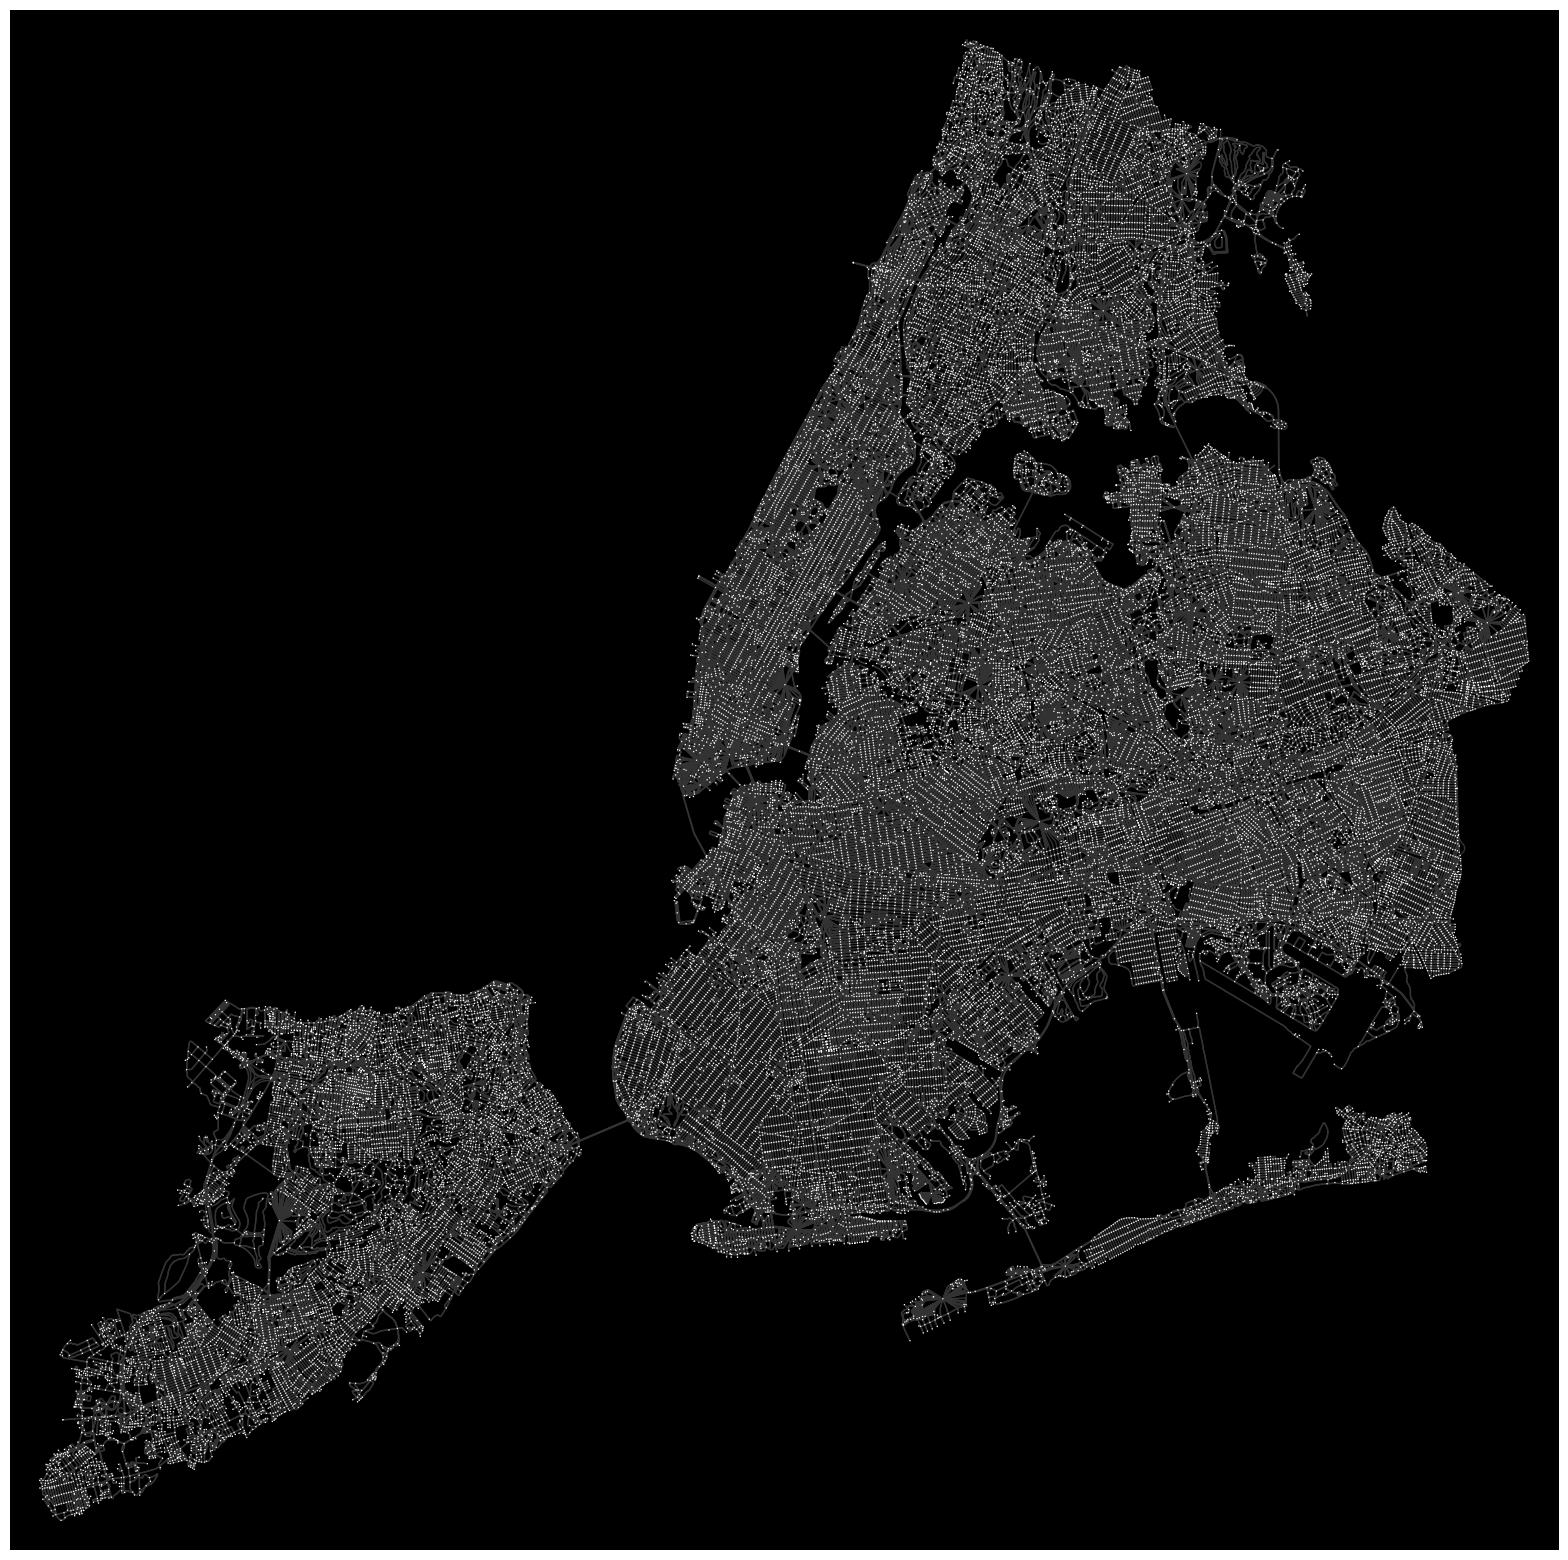

In [5]:
plot_graph(G)
plt.show()

## Aproximated distance

Instead of calculating the distance for all points we calculate only for pairs of neigborhood

In [6]:
G_undirected = G.to_undirected()

In [7]:
travel_times_path = 'datasets/travel_times_simplified.pkl'

if os.path.exists(travel_times_path):
    with open(travel_times_path, 'rb') as f:
        warnings.warn('Distance matrix is a pickled file: use only '
                        'from trusted sources')
        travel_times = pickle.load(f)
    print(f'loaded from file {travel_times_path}')
else:
    travel_times = data.compute_graph_distances(G_undirected)

    with open(travel_times_path, 'wb') as f:
        pickle.dump(travel_times, f)

/tmp/ipykernel_1455114/4079553272.py:5: UserWarning: Distance matrix is a pickled file: use only from trusted sources
  warnings.warn('Distance matrix is a pickled file: use only '


loaded from file datasets/travel_times_simplified.pkl


In [8]:
df = data.load_data().fetch(5_000_000)
df.head()

fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
f64,datetime[μs],f64,f64,f64,f64,i64
4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.84161,40.712278,1
16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
5.7,2011-08-18 00:35:00,-73.982738,40.76127,-73.991242,40.750562,2
7.7,2012-04-21 04:30:42,-73.98713,40.733143,-73.991567,40.758092,1
5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
kdtree = data.kdtree_from_graph(G)

In [10]:
df = df.with_columns(
    travel_time=pl.struct('pickup_longitude', 'pickup_latitude',
                          'dropoff_longitude', 'dropoff_latitude')
    .map(partial(data.fast_travel_distance,
                 distance_matrix=travel_times,
                 kdtree=kdtree)))
df.head()

100%|██████████| 5000000/5000000 [00:03<00:00, 1515969.15it/s]


fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,travel_time
f64,datetime[μs],f64,f64,f64,f64,i64,f64
4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.84161,40.712278,1,61.90625
16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,281.5
5.7,2011-08-18 00:35:00,-73.982738,40.76127,-73.991242,40.750562,2,86.3125
7.7,2012-04-21 04:30:42,-73.98713,40.733143,-73.991567,40.758092,1,134.875
5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,142.125


In [11]:
df = df.with_columns(data.euclidian_distance(df))
df.head()

fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,travel_time,travel_distance
f64,datetime[μs],f64,f64,f64,f64,i64,f64,f64
4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.84161,40.712278,1,61.90625,0.009436
16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,281.5,0.079696
5.7,2011-08-18 00:35:00,-73.982738,40.76127,-73.991242,40.750562,2,86.3125,0.013674
7.7,2012-04-21 04:30:42,-73.98713,40.733143,-73.991567,40.758092,1,134.875,0.02534
5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,142.125,0.01947


In [12]:
df.select(travel_time_pearson=pl.corr('travel_time', 'fare_amount'),
          travel_distance_pearson=pl.corr('travel_distance',
                                          'fare_amount'),
          travel_time_spearman=pl.corr('travel_time', 'fare_amount',
                                       method='spearman'),
          travel_distance_spearman=pl.corr(
            'travel_distance', 'fare_amount', method='spearman'),
)

travel_time_pearson,travel_distance_pearson,travel_time_spearman,travel_distance_spearman
f64,f64,f64,f64
0.848635,0.867366,0.797115,0.847916
